# Greenhouse gas benefit from fertilization of forest stands
### British Columbia's Forest Carbon Initiative

Robbie A Hember, PhD, P.Ag.

Last updated: 2020-03-17

Climate Change and Integrated Planning Branch,<br>
Office of the Chief Forester,<br>
Forests Lands, Natural Resource Operations and Rural Development<br>
Government of British Columbia<br>
545 Superior Street, Victoria, Canada<br>
robert.hember@gov.bc.ca

## Introduction

This project demonstrates nutrient management as a climate change mitigation activity in the forest sector. Examples are given for projects in coastal and interior regions of British Columbia, Canada. For each region, the greenhouse gas (GHG) benefit is calculated from the differnece between the project scenario (aerial fertilization at age 36) and the baseline scenario (no fertilization). The regional examples are done twice, first assuming they are not harvested before 2050, and second assuming they are harvested 15 years after fertilization (before 2050).

In [33]:
from IPython.core.display import display, HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show(); }
 code_show = !code_show} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="See code"></form>''')

## Methods

### Prepare session
First let's prepare the session in Jupyter Notebooks and import the required python packages. To do this work, we will use the model <i>cbrunner</i> from the <i>fcgadgets</i> repository. Set how graphic display parameters.

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from fcgadgets.pyscripts import utilities_general as gu
from fcgadgets.pyscripts import utilities_gis as gis
from fcgadgets.cbrunner.cbrun_utilities import *
from fcgadgets.cbrunner.cbrun import *
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:80% !important; } .output {align-items: left; }</style>"))

Import graphics parameters for FCI demos using the funciton, <i>fcgadgets.cbrunner.cbrun_Utilities.Import_GraphicsParameters</i>.

In [35]:
params_graphic=Import_GraphicsParameters('FCI Demo')
plt.rcParams.update(params_graphic)

### Prepare inputs
Start to configure the project based on project parameters and scenario parameters in ProjectConfig.xlsx. Set the directory path to the project data.

In [36]:
meta={}
#meta['Path Project']=r'Z:\!Workgrp\Forest Carbon\Data\FCI_Simulations\FCI_Demo_Fertilization'
meta['Path Project']=r'G:\My Drive\Data\FCI_Demo_Fertilization'
meta['Path Model Code']=r'G:\My Drive\Code_Python\fcgadgets\cbrunner'
meta=ImportProjectConfig(meta)

Considering two regions, two harvest schedules per region, and two treatment scenarios per region and harvest schedule yields a total of 8 scenarios:

    1) Coastal - no harvesting - baseline
    2) Coastal -  no harvesting - project
    3) Interior - no harvesting - baseline
    4) Interior - no harvesting - project
    5) Coastal - with harvesting - baseline
    6) Coastal - with harvesting - project
    7) Interior - with harvesting - baseline
    8) Interior - with harvesting - project

We will use the BC standard fertilization responses from the TIPSY/TASS growth and yield modelling framework to represent net growth of forests. Manually define the gorwth curves for each of these scenarios by populating the "GrowthCurvesTIPSY_Parameters.xlsx" spreadsheet. Then run the function <i>fcgadgets.cbrunner.cbrun_Utilities.BuildTIPSYInputs</i> to create the input file that is readable by BatchTIPSY.exe. 

In [37]:
BuildTIPSYInputs(meta)

Then open BatchTIPSY.exe. Inspect the settings in the .BTP file and run BatchTIPSY.exe.

Prepare the inventory input file for <i>fcgadgets.cbrunner</i>.

In [38]:
# Loop through batches, saving inventory to file
for iScn in range(0,meta['N Scenario']):
    
    # Loop through batches, saving inventory to file
    for iBat in range(0,meta['N Batch']):
      
        inv={}
    
        # Index to batch
        iStart=meta['Batch Interval']*iBat
        iStop=np.minimum(meta['N Stand Full'],iStart+meta['Batch Interval'])
        indBat=np.arange(iStart,iStop,1)    
        N_StandsInBatch=len(indBat)
    
        # Initialize inventory variables
        inv['Lat']=np.zeros((1,N_StandsInBatch))
        inv['Lon']=np.zeros((1,N_StandsInBatch))
        inv['X']=inv['Lat']
        inv['Y']=inv['Lon']
        
        # BEC zone
        inv['ID_BECZ']=meta['LUT BGC Zone']['CWH']*np.ones((1,N_StandsInBatch),dtype=np.int)                  
    
        # Temperature will be updated automatically
        inv['MAT']=4*np.ones((1,N_StandsInBatch))
    
        if meta['Biomass Module']=='Sawtooth':
            inv['Srs1_ID']=meta['LUT Spc'][meta['Scenario'][iScn]['SRS1_CD']]*np.ones((1,N_StandsInBatch),dtype=np.int)
        else:
            inv['Srs1_ID']=9999*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs1_Pct']=100*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs2_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs2_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs3_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs3_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc1_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc1_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc2_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc2_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc3_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc3_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)

        # Save
        gu.opickle(meta['Path Input Scenario'][iScn] + '\\Inventory_Bat' + FixFileNum(iBat) + '.pkl',inv)

Prepare the disturbance/management event history for <i>fcgadgets.cbrunner</i>.

In [39]:
for iScn in range(meta['N Scenario']):
    for iEns in range(meta['N Ensemble']):        
        for iBat in range(meta['N Batch']):
            # Index to batch
            iStart=meta['Batch Interval']*iBat
            iStop=np.minimum(meta['N Stand Full'],iStart+meta['Batch Interval'])
            indBat=np.arange(iStart,iStop,1)
            N_StandsInBatch=len(indBat)
    
            # Build disturbance history for each stand
            eh=list()
            for iStandBat in range(N_StandsInBatch):            
                ehS={}
        
                # Spinup disturbances
                ehS=CompileDisturbancesForSpinup(meta,iScn,ehS)

                # Simulated historical disturbances
                ehS=CompileHistoricalDisturbancesFromSimulation(meta,iScn,ehS)
                     
                # Disturbance from inventory (from spreadsheet)
                ehS=CompileDisturbancesFromInventory(meta,iScn,ehS)
            
                # Simulated future disturbances
                ehS=CompileFutureDisturbancesFromSimulation(meta,iScn,ehS)
            
                # Initialize custom disturbance variables
                for k in range(len(meta['Name CustDistVar'])):
                    ehS[meta['Name CustDistVar'][k]]=np.zeros(ehS['Year'].size,dtype=np.int16)
        
                # Add to Events structure
                eh.append(ehS)

            # Save to file            
            gu.opickle(meta['Path Input Scenario'][iScn] + '\\Disturbance_Ens' + FixFileNum(iEns) + '_Bat' + FixFileNum(iBat) + '.pkl',eh)


Prepare growth curves for <i>cbrunner</i> by running the function, <i>fcgadgets.cbrunner.cbrun_Utilities.PostProcessTIPSY</i>.

In [40]:
PostProcessTIPSY(meta)

### Run the simulation and import results
Import the raw forest sector carbon balance simulations using the function <i>fcgadgets.cburnner.cbrun_Utilities.LoadScenarioResults</i>. Then calculate the GHG balance for each scenario with the function, <i>fcgadgets.cburnner.cbrun_Utilities.CalculateGHGBalance</i>. Finally, import the growth curves fron BatchTIPSY with the function, <i>fcgadgets.cburnner.cbrun_Utilities.Import_BatchTIPSY_Output</i>. Put all the output variables in dictionaries.

In [41]:
RunProject(meta)
v1,meta=LoadScenarioResults(meta)
v2,meta=CalculateGHGBalance(v1,meta)
gc=Import_BatchTIPSY_Output(meta)

Running Scenario 0001, Ensemble 0001, Batch 0001
1.5486128330230713
Running Scenario 0002, Ensemble 0001, Batch 0001
1.3426907062530518
Running Scenario 0003, Ensemble 0001, Batch 0001
1.3201112747192383
Running Scenario 0004, Ensemble 0001, Batch 0001
1.2948198318481445
Running Scenario 0005, Ensemble 0001, Batch 0001
1.3110744953155518
Running Scenario 0006, Ensemble 0001, Batch 0001
1.3846840858459473
Running Scenario 0007, Ensemble 0001, Batch 0001
1.3150525093078613
Running Scenario 0008, Ensemble 0001, Batch 0001
1.3319642543792725


## Coastal Example
### Response of merchantable stemwood volume
The effect of the fertilizer is identifiable from differences in merchantable stemwood volume yield between the baseline and project scenarios after the year of application.

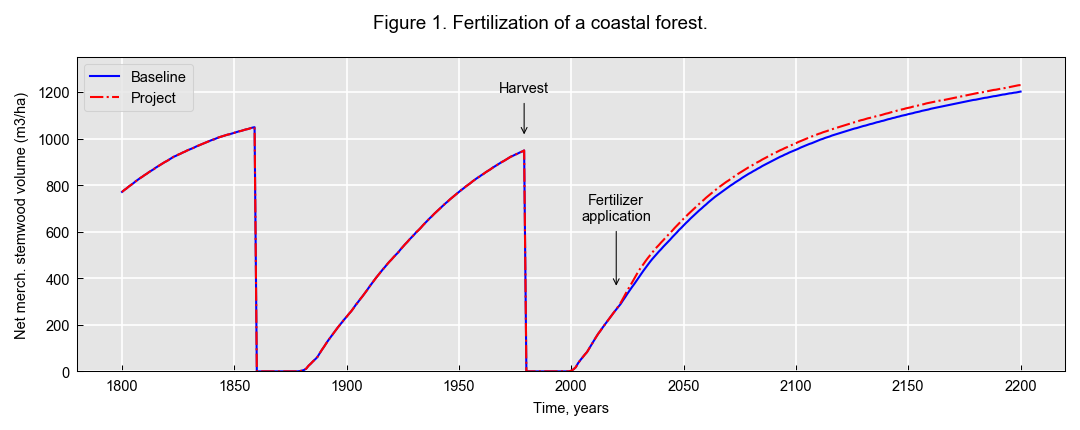

In [42]:
iT=np.where((v1[0].Year>=1800) & (v1[0].Year<=2200))[0]
fig,ax=plt.subplots(1,figsize=gu.cm2inch(18,7))
ax.plot(v1[0].Year[iT],v1[0].V_StemMerch[iT],'-',color=(0,0,1),label='Baseline')
ax.plot(v1[0].Year[iT],v1[1].V_StemMerch[iT],'-.',color=(1,0,0),label='Project')
ax.legend(loc='upper left')
ax.set(ylim=[0,1350],ylabel=r'Net merch. stemwood volume (m3/ha)',xlabel=r'Time, years');
ax.annotate('Harvest',xy=(meta['Year Project']-41,1000),xytext=(meta['Year Project']-41,1200),
            arrowprops={'color':'black','arrowstyle':'->'},ha='center');
ax.annotate('Fertilizer\napplication',xy=(meta['Year Project'],350),xytext=(meta['Year Project'],650),
            arrowprops={'color':'black','arrowstyle':'->'},ha='center');
plt.suptitle('Figure 1. Fertilization of a coastal forest.');

### Response of net sector GHG balance

The annual GHG benefit for a fertilization project is calculated from the difference in net sector GHG balance between the baseline and project sceanrios. Because the annual GHG benefit from fertilization depends strongly on time since fertilization (decreasing abruptly after the 10-year period of stimulation), it make sense to also look at the cumulative GHG benefit in future years in addition to the annual time series of GHG benefit. 

From these results, the initial GHG emissions from operations appear as a negative spike in GHG benefit during the year of fertilization. Operational emissions are then offset by the response of trees for the following ten years.

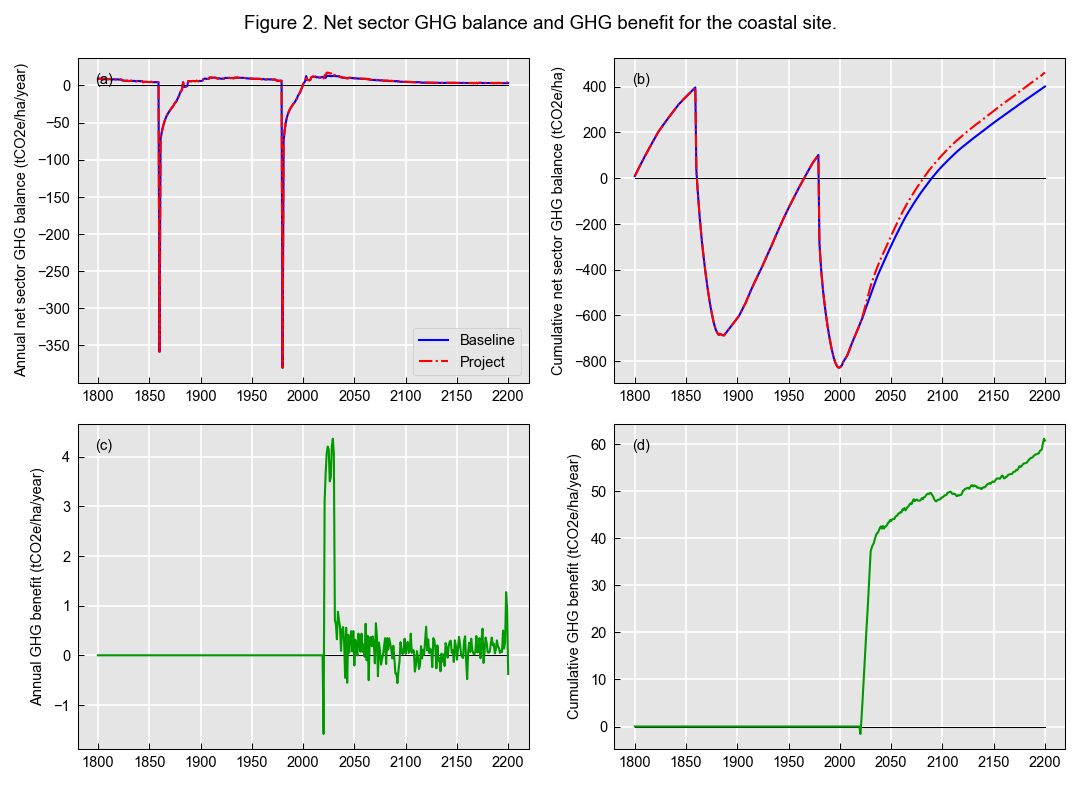

In [43]:
fig,ax=plt.subplots(2,2,figsize=gu.cm2inch(18,13))
ax[0,0].plot(v1[0].Year[iT],0*np.ones(iT.size),'-',linewidth=0.5,color=(0,0,0))
ax[0,0].plot(v1[0].Year[iT],v2[0].Sec_NGHGB[iT],'-',color=(0,0,1),label='Baseline')
ax[0,0].plot(v1[0].Year[iT],v2[1].Sec_NGHGB[iT],'-.',color=(1,0,0),label='Project')
ax[0,0].legend(loc="lower right")
ax[0,0].set(ylabel=r'Annual net sector GHG balance (tCO2e/ha/year)');

ax[0,1].plot(v1[0].Year[iT],0*np.ones(iT.size),'-',linewidth=0.5,color=(0,0,0))
ax[0,1].plot(v1[0].Year[iT],np.cumsum(v2[0].Sec_NGHGB[iT]),'-',color=(0,0,1),label='Baseline SR')
ax[0,1].plot(v1[0].Year[iT],np.cumsum(v2[1].Sec_NGHGB[iT]),'-.',color=(1,0,0),label='Baseline NSR')
ax[0,1].set(ylabel=r'Cumulative net sector GHG balance (tCO2e/ha)');

ax[1,0].plot(v1[0].Year[iT],0*np.ones(iT.size),'-',linewidth=0.5,color=(0,0,0))
ax[1,0].plot(v1[0].Year[iT],v2[1].Sec_NGHGB[iT]-v2[0].Sec_NGHGB[iT],'-',color=(0,0.6,0),
             label='Delta NSCB (Project minus Baseline SR)')
ax[1,0].set(ylabel=r'Annual GHG benefit (tCO2e/ha/year)');

ax[1,1].plot(v1[0].Year[iT],0*np.ones(iT.size),'-',linewidth=0.5,color=(0,0,0))
ax[1,1].plot(v1[0].Year[iT],np.cumsum(v2[1].Sec_NGHGB[iT])-np.cumsum(v2[0].Sec_NGHGB[iT]),'-',
             color=(0,0.6,0),label='Delta cumulative NSCB (Project minus Baseline SR)')
ax[1,1].set(ylabel=r'Cumulative GHG benefit (tCO2e/ha/year)');
gu.axletters(ax,plt,0.04,0.92)
fig.suptitle('Figure 2. Net sector GHG balance and GHG benefit for the coastal site.');

### Where does the sequestered CO<sub>2</sub> go?

If fertilization increases CO<sub>2</sub> sequestration, where does it all end up? According to this approach, a large fraction of the CO<sub>2</sub> ends up being stored as carbon in aboveground biomass, including stemwood, folaige, branches, and bark. Some carbon is also stored in roots belowground. Because the 10 years of stimulus from fertilizaton leads to greater amounts of biomass, the model assumes that this will lead to a proportional increase in turnover of foliage and fine roots. Some of that increase in turnover translates into increased storage of carbon in dead organic matter, including dead wood, litter, and soil.

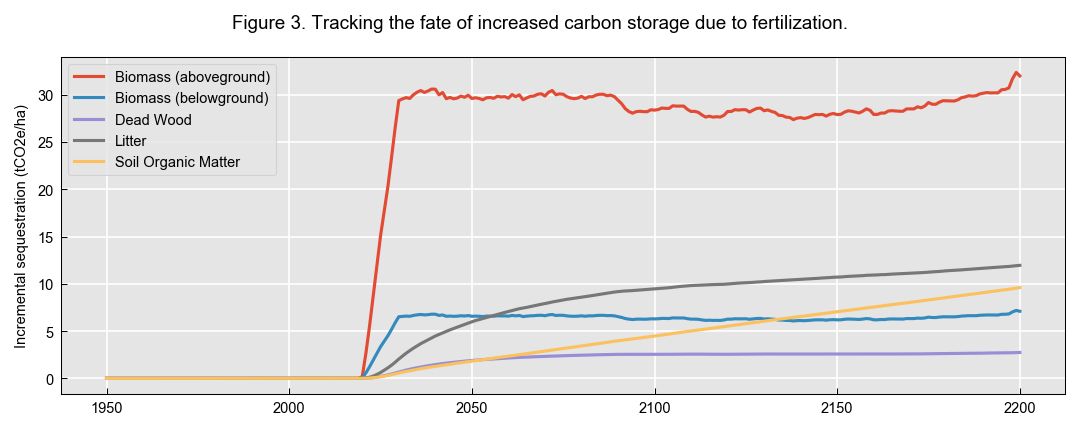

In [44]:
iT=np.where((v1[0].Year>=1950) & (v1[0].Year<=2200))[0]
for i in range(len(v1)):
    v1[i].Eco_BiomassAG=3.667*np.sum(v1[i].C_Eco_Pools[:,:,0:5],axis=2)
    v1[i].Eco_BiomassBG=3.667*np.sum(v1[i].C_Eco_Pools[:,:,5:7],axis=2)
    v1[i].Eco_BiomassAG[np.isnan(v1[i].Eco_BiomassAG)]=0
fig,ax=plt.subplots(1,figsize=gu.cm2inch(18,7))
ax.plot(v1[0].Year[iT],v1[1].Eco_BiomassAG[iT]-v1[0].Eco_BiomassAG[iT],'-',label='Biomass (aboveground)',linewidth=1.5)
ax.plot(v1[0].Year[iT],v1[1].Eco_BiomassBG[iT]-v1[0].Eco_BiomassBG[iT],'-',label='Biomass (belowground)',linewidth=1.5)
ax.plot(v1[0].Year[iT],v2[1].Eco_DeadWood[iT]-v2[0].Eco_DeadWood[iT],'-',label='Dead Wood',linewidth=1.5)
ax.plot(v1[0].Year[iT],v2[1].Eco_Litter[iT]-v2[0].Eco_Litter[iT],'-',label='Litter',linewidth=1.5)
ax.plot(v1[0].Year[iT],v2[1].Eco_Soil[iT]-v2[0].Eco_Soil[iT],'-',label='Soil Organic Matter',linewidth=1.5)
ax.legend(loc="upper left")
ax.set(ylabel=r'Incremental sequestration (tCO2e/ha)')
fig.suptitle('Figure 3. Tracking the fate of increased carbon storage due to fertilization.');

### How does future harvesting affect the GHG benefit?

The example illustrated thus ar did not take into account the possibility that the forest stand will be harvested at some time following fertilization. Here, we build on the coastal fertilization example by adding a harvest event 15 years after the fertilizer was applied. This is before the 2050 reporting goalpost. We assume that the forest stand is harvested in both the baseline and project scenarios.

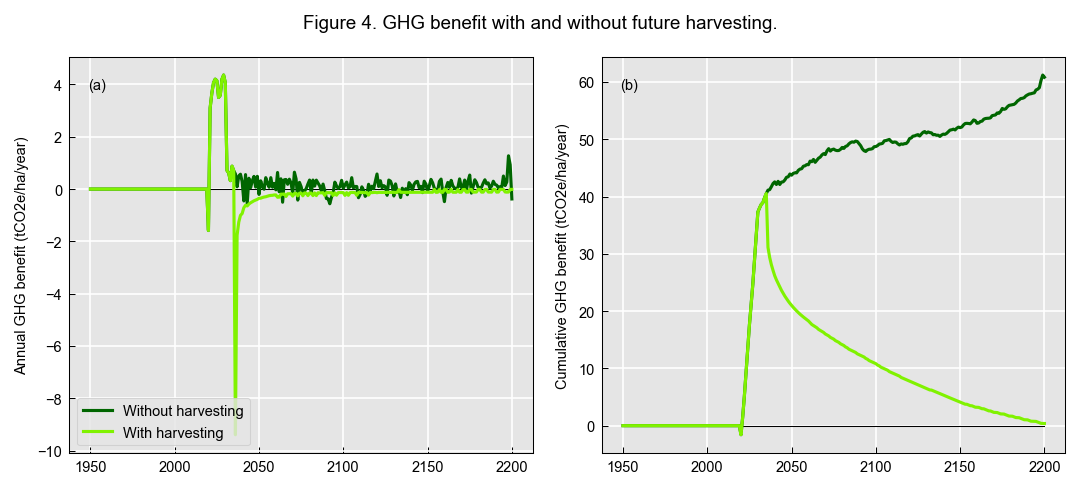

In [45]:
fig,ax=plt.subplots(1,2,figsize=gu.cm2inch(18,8))
ax[0].plot(v1[0].Year[iT],0*np.ones(iT.size),'-',linewidth=0.5,color=(0,0,0))
ax[0].plot(v1[0].Year[iT],v2[1].Sec_NGHGB[iT]-v2[0].Sec_NGHGB[iT],'-',color=(0,0.4,0),label='Without harvesting',linewidth=1.5)
ax[0].plot(v1[0].Year[iT],v2[5].Sec_NGHGB[iT]-v2[4].Sec_NGHGB[iT],'-',color=(0.5,0.95,0),label='With harvesting',linewidth=1.5)
ax[0].legend(loc="lower left")
ax[0].set(ylabel=r'Annual GHG benefit (tCO2e/ha/year)');

ax[1].plot(v1[0].Year[iT],0*np.ones(iT.size),'-',linewidth=0.5,color=(0,0,0))
ax[1].plot(v1[0].Year[iT],np.cumsum(v2[1].Sec_NGHGB[iT])-np.cumsum(v2[0].Sec_NGHGB[iT]),'-',color=(0,0.4,0),linewidth=1.5)
ax[1].plot(v1[0].Year[iT],np.cumsum(v2[5].Sec_NGHGB[iT])-np.cumsum(v2[4].Sec_NGHGB[iT]),'-',color=(0.5,0.95,0),linewidth=1.5)
ax[1].set(ylabel=r'Cumulative GHG benefit (tCO2e/ha/year)');
gu.axletters(ax,plt,0.04,0.92)
fig.suptitle('Figure 4. GHG benefit with and without future harvesting.');

## Summary of GHG Benefit for Coastal and Interior Examples

Finally, let's summarize the GHG benefit for both site examples, and with and without future harvesting. We will just focus on reporting the cumulative 2050 time horizon. Also reported is the mitigation cost, assuming a projected cost of fertilization of $538/ha.

In [46]:
it=np.where(v1[0].Year==2050)[0]
df=pd.DataFrame(columns=['Region','Harvest','Cum. 2050 GHG benefit (tCO2e/ha)','Cost ($/ha)','Cost efficiency ($/tCO2e)'])
df['Region']=['Coast','Coast','Interior','Interior']
df['Harvest']=['No','Yes','No','Yes']
# Coast:
totC=np.cumsum(v2[1].Sec_NGHGB)-np.cumsum(v2[0].Sec_NGHGB); df['Cum. 2050 GHG benefit (tCO2e/ha)'].iloc[0]=np.round(totC[it][0],decimals=1)
totI=np.cumsum(v2[5].Sec_NGHGB)-np.cumsum(v2[4].Sec_NGHGB); df['Cum. 2050 GHG benefit (tCO2e/ha)'].iloc[1]=np.round(totI[it][0],decimals=1)
df['Cost ($/ha)'][0:4]=530 
# Interior:
totC=np.cumsum(v2[3].Sec_NGHGB)-np.cumsum(v2[2].Sec_NGHGB); df['Cum. 2050 GHG benefit (tCO2e/ha)'].iloc[2]=np.round(totC[it][0],decimals=1)
totI=np.cumsum(v2[7].Sec_NGHGB)-np.cumsum(v2[6].Sec_NGHGB); df['Cum. 2050 GHG benefit (tCO2e/ha)'].iloc[3]=np.round(totI[it][0],decimals=1)
for i in range(4):
    df['Cost efficiency ($/tCO2e)'][i]=df['Cost ($/ha)'][i]/df['Cum. 2050 GHG benefit (tCO2e/ha)'][i]

df

,Region,Harvest,Cum. 2050 GHG benefit (tCO2e/ha),Cost ($/ha),Cost efficiency ($/tCO2e)
0,Coast,No,43.7,530,12.1281
1,Coast,Yes,21,530,25.2381
2,Interior,No,19,530,27.8947
3,Interior,Yes,8.4,530,63.0952


## Acknowledgements

This work was supported by Canada's Low Carbon Economy Leadership Fund (https://www.canada.ca/en/environment-climate-change/services/climate-change/low-carbon-economy-fund.html).